# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [23]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

import seaborn as sns

## Leitura, normalização e visualização dos dados

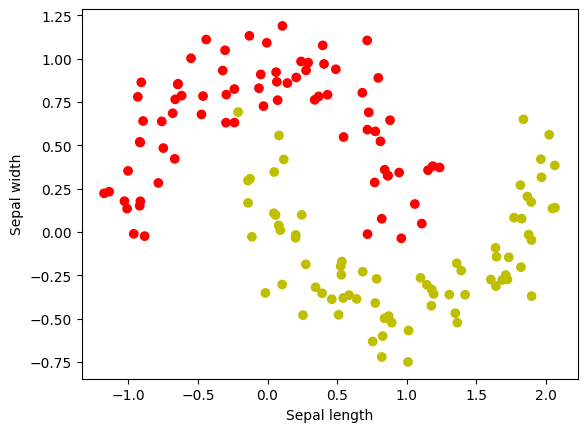

In [24]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [25]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [26]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [27]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [28]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [29]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.2165)


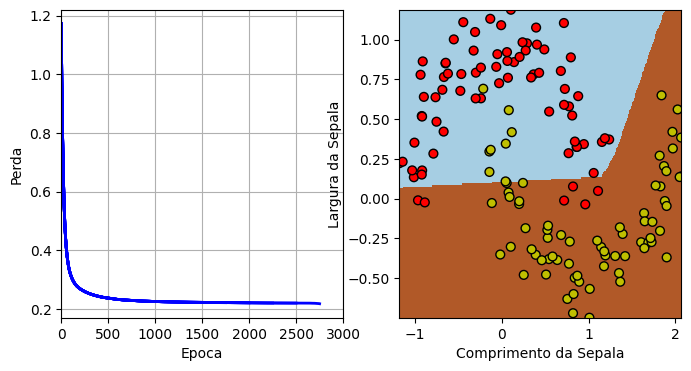

In [30]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [31]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[-0.3978, -0.1868],
        [-0.4679,  0.8847],
        [-0.7345, -0.4336],
        [ 1.3512, -0.5709],
        [ 0.0090, -0.7284]])
dense.0.bias    torch.Size([5])
tensor([ 0.9005,  1.0289,  1.0698, -1.4769,  0.1067])
dense.2.weight  torch.Size([5, 5])
tensor([[ 0.1969, -0.2500, -0.1076,  0.1161,  0.1644],
        [ 0.3095,  0.9747, -0.4214, -1.3204, -0.7457],
        [ 0.5112,  0.8965, -1.0543, -1.5025, -0.2369],
        [-0.0750,  0.0825,  0.2023, -0.2249, -0.4289],
        [-0.0845,  0.1272,  0.1577, -0.2697, -0.3068]])
dense.2.bias    torch.Size([5])
tensor([-0.2602,  0.7276,  0.4527, -0.4186, -0.4038])
dense.4.weight  torch.Size([3, 5])
tensor([[ 0.2446,  1.5985,  1.7023, -0.0406,  0.0705],
        [-0.0193, -0.4264, -1.1221,  0.3785,  0.2830],
        [-0.1814, -1.1017, -0.4229,  0.1954,  0.4088]])
dense.4.bias    torch.Size([3])
tensor([-1.7504,  3.8010, -2.6149])


### Avaliação do classificador

In [32]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.8933333333333333


### Matriz de confusão

In [33]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,69,10
1,6,65


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.

Final loss: tensor(0.2310)
Training Accuracy:  0.8733333333333333


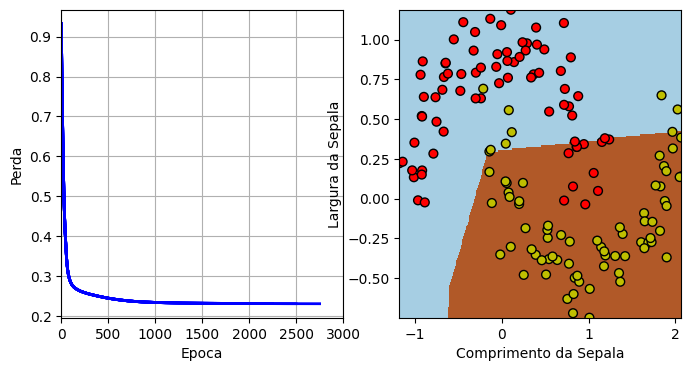

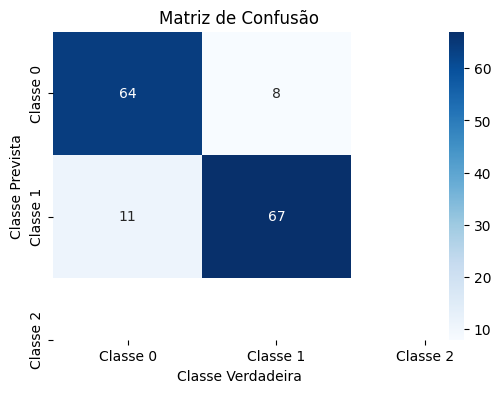

In [34]:
# Reduzindo a rede (menos neurônios e camadas)
class Modelo_p(nn.Module):
    def __init__(self):
        super(Modelo_p, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 3),
            nn.ReLU(),
            nn.Linear(3, 3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

# Inicializando o modelo
model_p = Modelo_p()
print(model_p)

# Hiperparâmetros
lr = 0.15
optimizer = torch.optim.SGD(model_p.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
batch_size = 150
nb_epoch = 3000

# Definindo o plotter
boundary_plot_p = BoundaryPlotter(model_p, Xc, Y, nb_epoch)

# Treinamento
boundary_plot_p.on_train_begin()
losses_p = []
for i in range(nb_epoch):
    # predict da rede
    output = model_p(Variable(X_tensor))
    # Calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_p.append(loss.data)
    boundary_plot_p.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# Avaliação
Y_hat_p = predict(model_p, X_tensor)
accuracy_p = (Y_hat_p == Y).mean()
print('Training Accuracy: ', accuracy_p)

# Matriz de Confusão
cm_p = pd.crosstab(Y_hat_p, Y)
# Exibir matriz de confusão como heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_p, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel("Classe Verdadeira")
plt.ylabel("Classe Prevista")
plt.title("Matriz de Confusão")
plt.show()

Final loss: tensor(0.0036)
Training Accuracy:  1.0


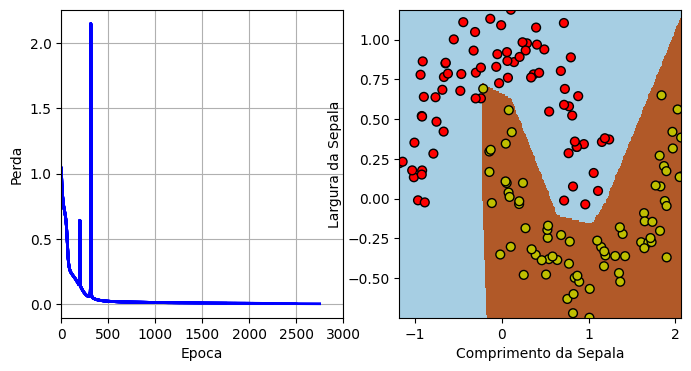

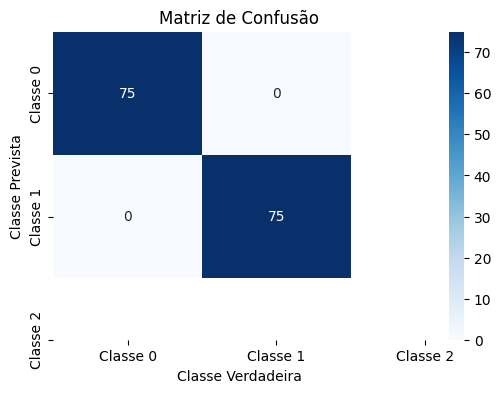

In [35]:
# Aumentando a rede (mais neurônios e camadas)
class Modelo_g(nn.Module):
    def __init__(self):
        super(Modelo_g, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

# Inicializando o modelo
model_g = Modelo_g()
print(model_g)

# Hiperparâmetros
lr = 0.15
optimizer = torch.optim.SGD(model_g.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
batch_size = 150
nb_epoch = 3000

# Definindo o plotter
boundary_plot_g = BoundaryPlotter(model_g, Xc, Y, nb_epoch)

# Treinamento
boundary_plot_g.on_train_begin()
losses_g = []
for i in range(nb_epoch):
    # predict da rede
    output = model_g(Variable(X_tensor))
    # Calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_g.append(loss.data)
    boundary_plot_g.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# Avaliação
Y_hat_g = predict(model_g, X_tensor)
accuracy_g = (Y_hat_g == Y).mean()
print('Training Accuracy: ', accuracy_g)

# Matriz de Confusão
cm_g = pd.crosstab(Y_hat_g, Y)
# Exibir matriz de confusão como heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_g, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel("Classe Verdadeira")
plt.ylabel("Classe Prevista")
plt.title("Matriz de Confusão")
plt.show()

**Conclusão:**
<br>Mais neurônios e camadas aumentam a capacidade da rede, mas também o risco de overfitting e o custo computacional.
<br>Redes menores são mais rápidas e fáceis de treinar, mas podem não capturar a complexidade dos dados, risco de underfitting.

2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.

Final loss: tensor(0.2699)
Training Accuracy:  0.9066666666666666


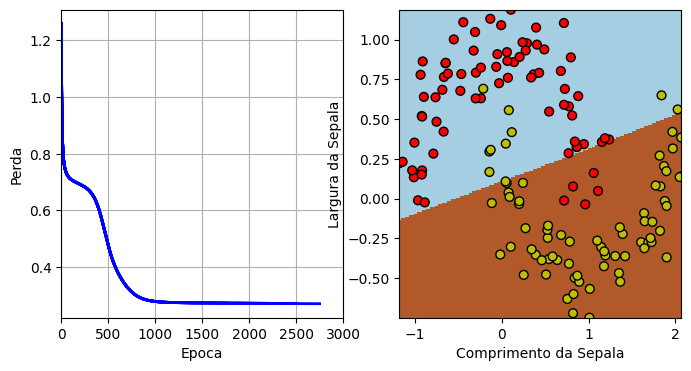

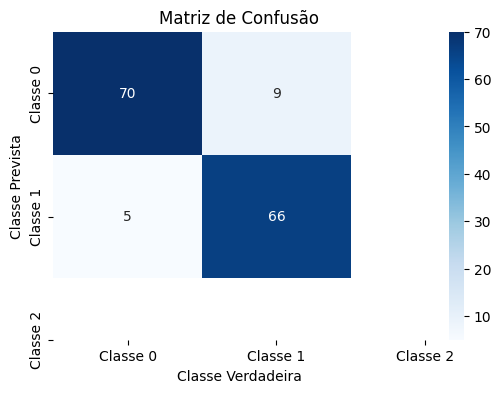

In [36]:
class Modelo_sig(nn.Module):
    def __init__(self):
        super(Modelo_sig, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

# Inicializando o modelo
model_sig = Modelo_sig()
print(model_sig)

# Hiperparâmetros
lr = 0.15
optimizer = torch.optim.SGD(model_sig.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
batch_size = 150
nb_epoch = 3000

# Definindo o plotter
boundary_plot_sig = BoundaryPlotter(model_sig, Xc, Y, nb_epoch)

# Treinamento
boundary_plot_sig.on_train_begin()
losses_sig = []
for i in range(nb_epoch):
    # predict da rede
    output = model_sig(Variable(X_tensor))
    # Calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_sig.append(loss.data)
    boundary_plot_sig.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# Avaliação
Y_hat_sig = predict(model_sig, X_tensor)
accuracy_sig = (Y_hat_sig == Y).mean()
print('Training Accuracy: ', accuracy_sig)

# Matriz de Confusão
cm_sig = pd.crosstab(Y_hat_sig, Y)
# Exibir matriz de confusão como heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sig, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel("Classe Verdadeira")
plt.ylabel("Classe Prevista")
plt.title("Matriz de Confusão")
plt.show()

**Conclusão:**
<br>O Final Loss com o Sigmoid foi maior do que com o ReLU, mas a acurácia também aumentou.
<br>O aprendizado com ReLU foi mais rápido e mais eficiente do que com Sigmoid, além das fronteiras não lineares se adaptarem melhor à distribuição dos dados.

3. O que ocorre quando não se utiliza ativação não linear entre camadas?

Final loss: tensor(0.2665)
Training Accuracy:  0.8866666666666667


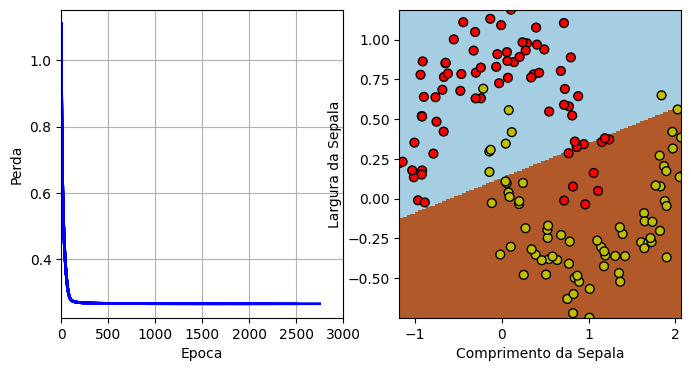

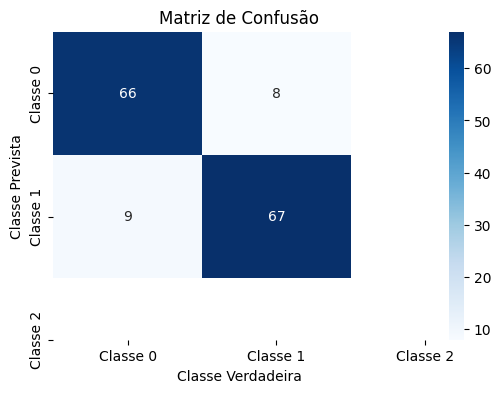

In [37]:
class Modelo_na(nn.Module):
    def __init__(self):
        super(Modelo_na, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 5),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

# Inicializando o modelo
model_na = Modelo_na()
print(model_na)

# Hiperparâmetros
lr = 0.15
optimizer = torch.optim.SGD(model_na.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
batch_size = 150
nb_epoch = 3000

# Definindo o plotter
boundary_plot_na = BoundaryPlotter(model_na, Xc, Y, nb_epoch)

# Treinamento
boundary_plot_na.on_train_begin()
losses_na = []
for i in range(nb_epoch):
    # predict da rede
    output = model_na(Variable(X_tensor))
    # Calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_na.append(loss.data)
    boundary_plot_na.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

# Avaliação
Y_hat_na = predict(model_na, X_tensor)
accuracy_na = (Y_hat_na == Y).mean()
print('Training Accuracy: ', accuracy_na)

# Matriz de Confusão
cm_na = pd.crosstab(Y_hat_na, Y)
# Exibir matriz de confusão como heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_na, annot=True, cmap="Blues", fmt="d",
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel("Classe Verdadeira")
plt.ylabel("Classe Prevista")
plt.title("Matriz de Confusão")
plt.show()

**Conclusão:**
<br>Múltiplas camadas lineares sem ativações não lineares são matematicamente equivalentes a uma única camada linear, ou seja, continua sendo apenas uma transformação linear.
<br>A rede não consegue aprender padrões complexos, como curvas ou fronteiras de decisão sofisticadas, perde profundidade útil e fica limitada a problemas linearmente separáveis.

## Principais aprendizados

Mais neurônios e camadas podem melhorar o desempenho da rede, mas aumentam também o risco de overfitting e o custo computacional.
<br>A função de ativação ReLU é preferível para redes profundas e com camadas ocultas. A Sigmoid é mais adequada para saídas binárias.
<br>A não utilização de ativação não linear entre camadas causa uma perda de profundidade útil da rede, que fica limitada a problemas linearmente separáveis.